# MESMER Tutorial
This is a tutorial for the use of MESMER. Here we demonstrate how MESMER is able to produce Earth System Model-specific spatio-temporally correlated temperature field realizations, taking annual global mean near surface temperature as input and emulating annual local near surface land temperature. We train the following modules of MESMER:

- **global trend module**: estimating the global temperature trend, including the volcanic influence on historical trends
- **global variablity module**: estimating the parameters to generate global variability
- **local trend module**: estimate parameters to translate global mean temperature (including variability) into locally resolved temperature
- **local variability module**: estimate parameters needed to generate local variability

We estimate the parameters using three scenarios: a historical, low emission (ssp119) and high emission (ssp585) scenario, each including several ensemble members.
Lastly, we use the calibrated parameters to produce emulations for a low and high emission scenario.

In [13]:
%load_ext autoreload
%autoreload 2
%xmode minimal
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Exception reporting mode: Minimal


In [14]:
import pathlib

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas
import xarray as xr
from datatree import DataTree, map_over_subtree
from filefisher import FileContainer, FileFinder

import mesmer

# Load data

MESMER is Earth System Model specific, aiming to reproduce to some extent the behaviour of one ESM. Here we rain on the CIMP-6 New Generation output of the model IPSL-CM6A-LR.

In [15]:
model = "IPSL-CM6A-LR"

We use filefinder to search all files in the cmip6 archive for the model and scenarios we want to use. You can read about file finder [here](https://github.com/mathause/filefinder). It can search through paths for certain file patterns. It returns all paths for the pattern you searched for so that you can load the files in a next step.

Here, we want to find all files that have data for annual near surface temperature (tas) for the model we use and the future scenarios ssp119 and ssp585. It is the users responsibility to name the datafiles according to a pattern holding this information. We will load all ensemble members available for these scenarios. As a next step, we search for the historical data that match the members found for the two future scenarios.

In [16]:
# data_path =  pathlib.Path("/Users/vbauer/fog/net/ch4/data/cmip6-Next_Generation/")
data_path = pathlib.Path("/Users/vbauer/atmos/net/ch4/data/cmip6-Next_Generation/")

CMIP_FILEFINDER = FileFinder(
    path_pattern=data_path / "{variable}/{time_res}/{resolution}",
    file_pattern="{variable}_{time_res}_{model}_{scenario}_{member}_{resolution}.nc",
)

In [17]:
scenarios = ["ssp585", "ssp119"]
fc_scens = CMIP_FILEFINDER.find_files(
    variable="tas", scenario=scenarios, model=model, resolution="g025", time_res="ann"
)

# only get the historical members that are also in the future scenarios, but only once
unique_scen_members = fc_scens.df.member.unique()

fc_hist = CMIP_FILEFINDER.find_files(
    variable="tas",
    scenario="historical",
    model=model,
    resolution="g025",
    time_res="ann",
    member=unique_scen_members,
)

fc_all = FileContainer(pandas.concat([fc_hist.df, fc_scens.df]))
fc_all.df

,filename,variable,time_res,resolution,model,scenario,member
0,/Users/vbauer/atmos/net/ch4/data/cmip6-Next_Ge...,tas,ann,g025,IPSL-CM6A-LR,historical,r1i1p1f1
1,/Users/vbauer/atmos/net/ch4/data/cmip6-Next_Ge...,tas,ann,g025,IPSL-CM6A-LR,historical,r2i1p1f1
2,/Users/vbauer/atmos/net/ch4/data/cmip6-Next_Ge...,tas,ann,g025,IPSL-CM6A-LR,historical,r3i1p1f1
3,/Users/vbauer/atmos/net/ch4/data/cmip6-Next_Ge...,tas,ann,g025,IPSL-CM6A-LR,historical,r4i1p1f1
4,/Users/vbauer/atmos/net/ch4/data/cmip6-Next_Ge...,tas,ann,g025,IPSL-CM6A-LR,historical,r6i1p1f1
5,/Users/vbauer/atmos/net/ch4/data/cmip6-Next_Ge...,tas,ann,g025,IPSL-CM6A-LR,historical,r14i1p1f1
6,/Users/vbauer/atmos/net/ch4/data/cmip6-Next_Ge...,tas,ann,g025,IPSL-CM6A-LR,historical,r33i1p1f1
0,/Users/vbauer/atmos/net/ch4/data/cmip6-Next_Ge...,tas,ann,g025,IPSL-CM6A-LR,ssp585,r1i1p1f1
1,/Users/vbauer/atmos/net/ch4/data/cmip6-Next_Ge...,tas,ann,g025,IPSL-CM6A-LR,ssp585,r2i1p1f1
2,/Users/vbauer/atmos/net/ch4/data/cmip6-Next_Ge...,tas,ann,g025,IPSL-CM6A-LR,ssp585,r3i1p1f1


Now we load all the files we found that match the desired critera into a ``DataTree``. ``DataTree`` is a data structure provided by [xarray](https://docs.xarray.dev/en/stable/index.html). It currently still lives in it's own [repository](https://github.com/xarray-contrib/datatree) but is planned to move to the xarray repo soon. Until then, you can find the documentation [here](https://xarray-datatree.readthedocs.io/en/latest/).

Essentially, datatree is a container to hold xarray datasets with datavariables that are not mutually alignable. This is useful for us since we have historical and future data, the two of which have different time coordinates. Moreover, different scenarios might also have different numbers of timesteps or different numbers of members. Thus, we store the data of each sceanrio in a `xarray.Dataset` holding all its ensemble members along a `member` dimension. Then we store all the scenario datasets in one `DataTree`. The `DataTree` allows us to perform computations that we want to perform on each of the datasets in a nicely readable and quick way, as you will see later on.

In [18]:
dt = DataTree()

scenarios_whist = scenarios.copy()
scenarios_whist.append("historical")

# load data for each scenario
for scen in scenarios_whist:
    files = fc_all.search(scenario=scen)

    # load all members for a scenario
    members = []
    for fN, meta in files:
        ds = xr.open_dataset(fN, use_cftime=True)
        # drop unnecessary variables
        ds = ds.drop_vars(["height", "time_bnds", "file_qf"], errors="ignore")
        # assign member-ID as coordinate
        ds = ds.assign_coords({"member": meta["member"]})
        members.append(ds)

    # create a Dataset that holds each member along the member dimension
    scen_data = xr.concat(members, dim="member")
    # put the scenario dataset into the DataTree
    dt[f"{scen}"] = DataTree(scen_data)

dt

DataTree('None', parent=None)
├── DataTree('ssp585')
│       Dimensions:  (time: 86, lon: 144, lat: 72, member: 7)
│       Coordinates:
│         * time     (time) object 688B 2015-07-01 06:00:00 ... 2100-07-01 06:00:00
│         * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
│         * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
│         * member   (member) <U9 252B 'r1i1p1f1' 'r2i1p1f1' ... 'r14i1p1f1' 'r33i1p1f1'
│       Data variables:
│           tas      (member, time, lat, lon) float64 50MB 225.1 225.0 ... 278.7 278.7
│       Attributes: (12/56)
│           CDI:                       Climate Data Interface version 1.9.6 (http://m...
│           history:                   Fri Jun 12 10:47:17 2020: cdo -O -b F64 -remap...
│           source:                    IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96; ...
│           institution:               Institut Pierre Simon Laplace, Paris 75252, Fr...
│           Conventions:               CF-1.7 CMIP-6.2
│           name:                      /ccc/work/cont003/gencmip6/oboucher/IGCM_OUT/I...
│           ...                        ...
│           dr2xml_md5sum:             c2dce418e78ca835be1e2ff817c2c403
│           model_version:             6.1.8
│           cmip6-ng:                  \ncontact = cmip6-archive@env.ethz.ch\ndescrip...
│           original_file_names:       /net/atmos/data/cmip6/ssp585/Amon/tas/IPSL-CM6...
│           original_file_hash_codes:  a2117793ca25ad66f75a37be51fd2e6165c2ba2684b7d4...
│           CDO:                       Climate Data Operators version 1.9.6 (http://m...
├── DataTree('ssp119')
│       Dimensions:  (time: 86, lon: 144, lat: 72, member: 6)
│       Coordinates:
│         * time     (time) object 688B 2015-07-01 06:00:00 ... 2100-07-01 06:00:00
│         * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
│         * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
│         * member   (member) <U9 216B 'r1i1p1f1' 'r2i1p1f1' ... 'r6i1p1f1' 'r14i1p1f1'
│       Data variables:
│           tas      (member, time, lat, lon) float64 43MB 224.8 224.7 ... 264.0 264.1
│       Attributes: (12/57)
│           CDI:                       Climate Data Interface version 1.9.6 (http://m...
│           history:                   Fri Dec 20 14:40:12 2019: cdo -O -b F64 -remap...
│           source:                    IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96; ...
│           institution:               Institut Pierre Simon Laplace, Paris 75252, Fr...
│           Conventions:               CF-1.7 CMIP-6.2
│           name:                      /ccc/work/cont003/gencmip6/lurtont/IGCM_OUT/IP...
│           ...                        ...
│           parent_activity_id:        CMIP
│           NCO:                       "4.6.0"
│           cmip6-ng:                  \ncontact = cmip6-archive@env.ethz.ch\ndescrip...
│           original_file_names:       /net/atmos/data/cmip6/ssp119/Amon/tas/IPSL-CM6...
│           original_file_hash_codes:  01cfee823c51137de6c756dea6ba51ec4fc131a3132fa2...
│           CDO:                       Climate Data Operators version 1.9.6 (http://m...
└── DataTree('historical')
        Dimensions:  (time: 165, lon: 144, lat: 72, member: 7)
        Coordinates:
          * time     (time) object 1kB 1850-07-01 06:00:00 ... 2014-07-01 06:00:00
          * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
          * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
          * member   (member) <U9 252B 'r1i1p1f1' 'r2i1p1f1' ... 'r14i1p1f1' 'r33i1p1f1'
        Data variables:
            tas      (member, time, lat, lon) float64 96MB 225.2 225.0 ... 259.5 259.5
        Attributes: (12/56)
            CDI:                       Climate Data Interface version 1.9.6 (http://m...
            history:                   Thu Dec 19 16:26:00 2019: cdo -O -b F64 -remap...
            source:

We will need some configuration parameters in the follwing:
1. ``THRESHOLD_LAND``: Threshold above which land fraction to consider a grid point as a land grid point.
2. ``REFERENCE_PERIOD``: We will work not with abolute temperature values but with temperature anomalies w.r.t. a reference period
3. ``HIST_PERIOD``: the historical time period

In [19]:
# some configuration parameters
THRESHOLD_LAND = 1 / 3

REFERENCE_PERIOD = slice("1850", "1900")

HIST_PERIOD = slice("1850", "2014")

In [20]:
# calculate anomalies w.r.t. the reference period
ref = dt["historical"].sel(time=REFERENCE_PERIOD).mean("time")
tas_anoms = dt - ref.ds

## Volcanic contributions
The volcanic contributions to the global mean temperature trend of the historical period have to be removed in order to estimate the linear regression of global mean temperature to local temperature.

1. Calculate global mean and smooth the forcing data using a lowess smoother, using 50 time steps to calculate `freq`. 

In [21]:
# make global mean
global_mean_dt = map_over_subtree(mesmer.weighted.global_mean)
tas_globmean = global_mean_dt(tas_anoms)
tas_globmean

DataTree('None', parent=None)
├── DataTree('ssp585')
│       Dimensions:  (time: 86, member: 7)
│       Coordinates:
│         * time     (time) object 688B 2015-07-01 06:00:00 ... 2100-07-01 06:00:00
│         * member   (member) <U9 252B 'r1i1p1f1' 'r2i1p1f1' ... 'r14i1p1f1' 'r33i1p1f1'
│       Data variables:
│           tas      (member, time) float64 5kB 1.342 1.67 1.803 ... 6.581 6.584 6.861
├── DataTree('ssp119')
│       Dimensions:  (time: 86, member: 6)
│       Coordinates:
│         * time     (time) object 688B 2015-07-01 06:00:00 ... 2100-07-01 06:00:00
│         * member   (member) <U9 216B 'r1i1p1f1' 'r2i1p1f1' ... 'r6i1p1f1' 'r14i1p1f1'
│       Data variables:
│           tas      (member, time) float64 4kB 1.211 1.527 1.717 ... 1.823 1.605 1.671
└── DataTree('historical')
        Dimensions:  (time: 165, member: 7)
        Coordinates:
          * time     (time) object 1kB 1850-07-01 06:00:00 ... 2014-07-01 06:00:00
          * member   (member) <U9 252B 'r1i1p1f1' 'r2i1p1f1' ... 'r14i1p1f1' 'r33i1p1f1'
        Data variables:
            tas      (member, time) float64 9kB -0.2139 -0.03273 ... 1.243 1.337

In [22]:
# mean over members before smoothing
n_steps = 50
lowess_dt = map_over_subtree(mesmer.stats.lowess)
tas_globmean_smoothed = lowess_dt(
    tas_globmean.mean(dim="member"), dim="time", n_steps=n_steps, use_coords=False
)

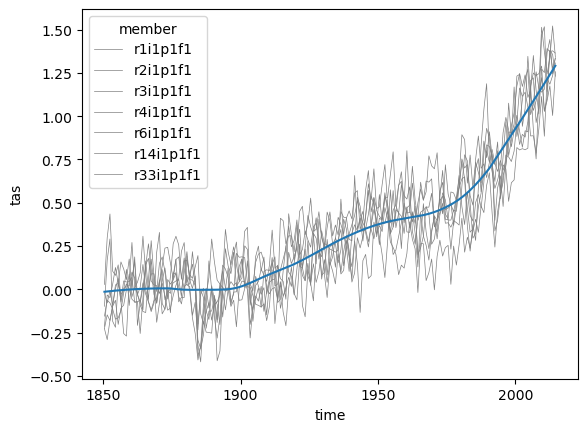

In [23]:
# plot historical
tas_globmean["historical"].tas.plot.line(x="time", color="grey", lw=0.5)
tas_globmean_smoothed["historical"].tas.plot.line(x="time")
plt.show()

2. Fit the parameter of the volcanic contributions only on the historical smoothed data of all ensemble members available. The future scenarios do not have volcanic contributions.

In [24]:
# tas_globmean_hist = tas_global_mean.sel(time=HIST_PERIOD).mean(dim="scenario")
hist_tas_residuals = tas_globmean["historical"] - tas_globmean_smoothed["historical"]

# fit volcanic influence
volcanic_params = mesmer.volc.fit_volcanic_influence(
    hist_tas_residuals.tas, hist_period=HIST_PERIOD, dim="time"
)

volcanic_params.aod

<xarray.DataArray 'aod' ()> Size: 8B
array(-1.6795828)

3. Superimpose the volcanic influence on the historical time series. Note that due to the approach to handle the historical data as its own scenario, we ecounter discontinuities at the boundary between historical and future period. However, this is not relevant for the fitting of the parameters hereafter.

In [25]:
# superimpose the volcanic forcing on historical data
tas_globmean_smoothed["historical"] = mesmer.volc.superimpose_volcanic_influence(
    tas_globmean_smoothed["historical"],
    volcanic_params,
    hist_period=HIST_PERIOD,
    dim="time",
)

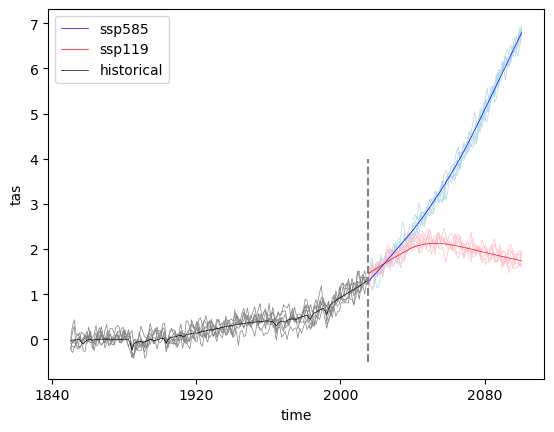

In [26]:
# some plotting
f, ax = plt.subplots()

# plot unsmoothed global means
tas_globmean["ssp585"].tas.plot.line(
    ax=ax, lw=0.5, x="time", color="lightblue", add_legend=False
)
tas_globmean["ssp119"].tas.plot.line(
    ax=ax, lw=0.5, x="time", color="pink", add_legend=False
)
tas_globmean["historical"].tas.plot.line(
    ax=ax, lw=0.5, x="time", color="grey", add_legend=False
)

# plot smoothed global means including volcanic influence for historical
tas_globmean_smoothed["ssp585"].tas.plot.line(
    ax=ax, lw=0.5, x="time", color="blue", label="ssp585"
)
tas_globmean_smoothed["ssp119"].tas.plot.line(
    ax=ax, lw=0.5, x="time", color="red", label="ssp119"
)
tas_globmean_smoothed["historical"].tas.plot.line(
    ax=ax, lw=0.5, x="time", color="black", label="historical"
)

plt.legend()

# xmax = tas_globmean["ssp585"].time.sel(time="2020").item()
# ax.set_xlim(None, xmax)
histend = tas_globmean["ssp585"].time.sel(time="2015").item()
ax.vlines(histend, -0.5, 4.0, color="0.5", linestyle="--")
# ax.set_ylim(-0.5, 4.0)
ax.set_title("")
plt.show()

4. Calculate residuals (wrt smoothed ts) i.e. remove the smoothed global mean, including the volcanic influence from the anomalies.

In [53]:
tas_globmean_resids = tas_globmean - tas_globmean_smoothed

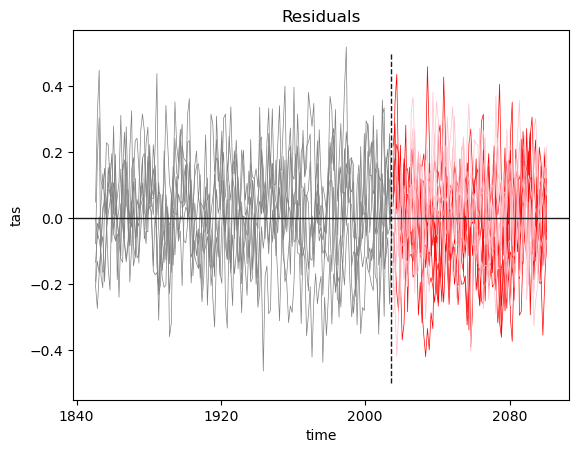

In [28]:
# plot residuals
tas_globmean_resids["ssp585"].tas.plot.line(
    x="time", color="red", lw=0.5, add_legend=False
)
tas_globmean_resids["ssp119"].tas.plot.line(
    x="time", color="pink", lw=0.5, add_legend=False
)
tas_globmean_resids["historical"].tas.plot.line(
    x="time", color="grey", lw=0.5, add_legend=False
)


plt.title("Residuals")
plt.axhline(0, lw=1, color="0.1")
histend = tas_globmean_resids["historical"].time.sel(time="2014").item()
plt.vlines(histend, -0.5, 0.5, color="0.1", linestyle="--", lw=1)
plt.show()
# TODO add legend for the scenarios

## Global variability

In this step we want to fit an AR process for predicting global variability, taking in the smoothed global mean temperature as follows:

$T_{t}^{glob, var} = \alpha_0 + \sum\limits_{k=1}^{k=p} \alpha_k \cdot T_{t-k}^{glob, var} + \varepsilon_t,\ \varepsilon_t \sim \mathcal{N}(0, \sigma)$

We first estimate the order of the AR process and then fit the parameters. Internally, we fit the parameters for each member and then average first over the parameters of each scenario and then over all scenarios to arrive at a single set of parameters.

In [29]:
data = (
    tas_globmean_resids["historical"].tas,
    tas_globmean_resids["ssp119"].tas,
    tas_globmean_resids["ssp585"].tas,
)

ar_order = mesmer.stats._select_ar_order_scen_ens(
    *data, dim="time", ens_dim="member", maxlag=12, ic="bic"
)

global_ar_params = mesmer.stats._fit_auto_regression_scen_ens(
    *data, dim="time", ens_dim="member", lags=ar_order
)

global_ar_params
# TODO: drop nobs internally, rewrite the function to work on datatrees instead of the tuple

<xarray.Dataset> Size: 56B
Dimensions:    (lags: 2)
Coordinates:
  * lags       (lags) int64 16B 1 2
Data variables:
    intercept  float64 8B 0.003674
    coeffs     (lags) float64 16B 0.4943 -0.1615
    variance   float64 8B 0.01397
    nobs       float64 8B 110.3

## Local forced response
Now we need to estimate how the global trend translates into a local forced response. This is done using a linear regression of the global trend and the global variability as predictors:

$T_{s,t}^{resp} = \beta_s^{trend} \cdot T_t^{glob, trend} + \beta_s^{int} + \beta_s^{var} \cdot T_t^{glob, var}$

To this end, we stack all values (members, scenarios) into a single dataset, the only important thing is that predictor and predicted values stay together.

We need to prepare the local temperature data:

1. Mask out ocean grid points (where the land fraction is larger than `THRESHOLD_LAND`)
2. Mask out Antarctica
3. Convert the data from a 2D lat-lon grid to a 1D grid by stacking it and removing all gridcells that were previously masked out.



Before stacking, we extract the original grid. We need to save this together with the parameters to later be able to reconstruct the original grid from the gridpoints.

In [54]:
# extract original grid
grid_orig = tas_anoms["historical"].ds[["lat", "lon"]]

In [30]:
def mask_and_stack(ds, threshold_land):
    ds = mesmer.mask.mask_ocean_fraction(ds, threshold_land)
    ds = mesmer.mask.mask_antarctica(ds)
    ds = mesmer.grid.stack_lat_lon(ds)
    return ds


mask_and_stack_dt = map_over_subtree(mask_and_stack)

In [32]:
# mask and stack the data
tas_stacked = mask_and_stack_dt(tas_anoms, THRESHOLD_LAND)

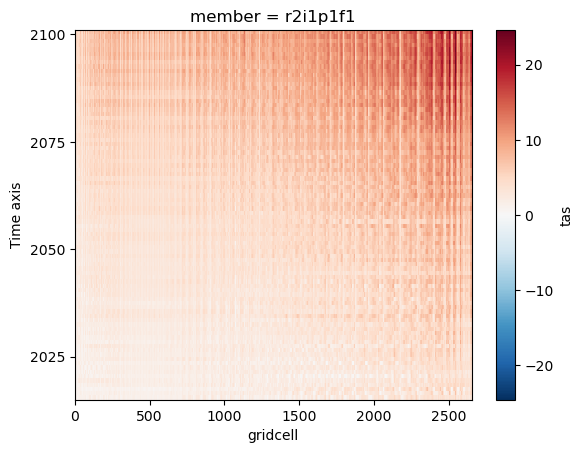

In [33]:
tas_stacked["ssp585"].tas.isel(member=1).plot()

In [34]:
# broadcast so all datasets have all the dimensions
tas_globmean_smoothed_bc = tas_globmean_smoothed.broadcast_like(
    tas_stacked, exclude={"gridcell"}
)
tas_globmean_resids_bc = tas_globmean_resids.broadcast_like(
    tas_stacked, exclude={"gridcell"}
)

In [112]:
def create_equal_scenario_weights_from_datatree(dt, member_dim="member") -> DataTree:
    """
    Create a DataTree holding the weights for each sceanrio to weight the members of each
    scenario such that each scenario contributes equally to some fitting procedure.
    The weight of each member = 1 / number of members in the scenario.

    Thus, if all scenarios have equal amounts of members, all weights will be equal.
    If one scenario has more members than the others, the weights will be smaller for each member of this scenario.

    Parameters:
    -----------
    dt : DataTree
        DataTree holding the data for which the weights should be created.
    member_dim : str
        Name of the dimension along which the weights should be created. Default is "member".

    Returns:
    --------
    DataTree
        DataTree holding the weights for each scenario.

    Example:
    --------
    dt = DataTree()
    dt["ssp119"] = DataTree(xr.Dataset({"tas": xr.DataArray([1, 2, 3], dims="member")}))
    dt["ssp585"] = DataTree(xr.Dataset({"tas": xr.DataArray([4, 5], dims="member")}))
    create_equal_scenario_weights_from_datatree(dt)
    # Output:
    # DataTree({
    #     "ssp119": DataTree({"weights": xr.DataArray([0.333333, 0.333333, 0.333333], dims="member")}),
    #     "ssp585": DataTree({"weights": xr.DataArray([0.5, 0.5], dims="member")})
    # })

    """
    if dt.depth > 1:
        raise ValueError("DataTree must have a depth of 1.")

    def _create_weights(ds):

        if member_dim not in ds.dims:
            raise ValueError(f"Member dimension '{member_dim}' not found in dataset.")

        data_vars = list(ds.keys())
        if len(data_vars) > 1:
            raise ValueError("Dataset must have only one data variable.")

        weights = xr.ones_like(ds).rename({data_vars[0]: "weights"})

        return weights / ds[member_dim].size

    weights = map_over_subtree(_create_weights)(dt)

    return weights

In [114]:
# create weights
weights = create_equal_scenario_weights_from_datatree(tas_stacked)
weights

DataTree('None', parent=None)
├── DataTree('ssp585')
│       Dimensions:  (time: 86, member: 7, gridcell: 2652)
│       Coordinates:
│         * time     (time) object 688B 2015-07-01 06:00:00 ... 2100-07-01 06:00:00
│         * member   (member) <U9 252B 'r1i1p1f1' 'r2i1p1f1' ... 'r14i1p1f1' 'r33i1p1f1'
│           lat      (gridcell) float64 21kB -53.75 -53.75 -51.25 ... 83.75 83.75 83.75
│           lon      (gridcell) float64 21kB 288.8 291.2 286.2 ... 328.8 331.2 333.8
│       Dimensions without coordinates: gridcell
│       Data variables:
│           weights  (member, time, gridcell) float64 13MB 0.1429 0.1429 ... 0.1429
├── DataTree('ssp119')
│       Dimensions:  (time: 86, member: 6, gridcell: 2652)
│       Coordinates:
│         * time     (time) object 688B 2015-07-01 06:00:00 ... 2100-07-01 06:00:00
│         * member   (member) <U9 216B 'r1i1p1f1' 'r2i1p1f1' ... 'r6i1p1f1' 'r14i1p1f1'
│           lat      (gridcell) float64 21kB -53.75 -53.75 -51.25 ... 83.75 83.75 83.75
│           lon      (gridcell) float64 21kB 288.8 291.2 286.2 ... 328.8 331.2 333.8
│       Dimensions without coordinates: gridcell
│       Data variables:
│           weights  (member, time, gridcell) float64 11MB 0.1667 0.1667 ... 0.1667
└── DataTree('historical')
        Dimensions:  (time: 165, member: 7, gridcell: 2652)
        Coordinates:
          * time     (time) object 1kB 1850-07-01 06:00:00 ... 2014-07-01 06:00:00
          * member   (member) <U9 252B 'r1i1p1f1' 'r2i1p1f1' ... 'r14i1p1f1' 'r33i1p1f1'
            lat      (gridcell) float64 21kB -53.75 -53.75 -51.25 ... 83.75 83.75 83.75
            lon      (gridcell) float64 21kB 288.8 291.2 286.2 ... 328.8 331.2 333.8
        Dimensions without coordinates: gridcell
        Data variables:
            weights  (member, time, gridcell) float64 25MB 0.1429 0.1429 ... 0.1429

In [36]:
# concat scenarios into one dataset
def collapse_datatree_into_dataset(dt, dim):
    ds = xr.concat([leaf.ds for leaf in dt.leaves], dim=dim)
    ds = ds.assign_coords({dim: [leaf.name for leaf in dt.leaves]})
    return ds


tas_local_ds = collapse_datatree_into_dataset(tas_stacked, dim="scenario")
tas_glob_smoothed_ds = collapse_datatree_into_dataset(
    tas_globmean_smoothed_bc, dim="scenario"
)
tas_glob_resid_ds = collapse_datatree_into_dataset(
    tas_globmean_resids_bc, dim="scenario"
)
weights_ds = collapse_datatree_into_dataset(weights, dim="scenario")

Try switching stacking and collapsing - maybe then we do not need to remove nas- doesn't work because we want to have sceanrio dim already in there, assigning it before is not pretty

In [37]:
# stack the dimensions and drop nans
tas_local_ds = tas_local_ds.stack(
    sample=("time", "member", "scenario"), create_index=False
)
tas_local_ds = tas_local_ds.dropna("sample")

predictors = {
    "tas_globmean": tas_glob_smoothed_ds,
    "tas_globmean_resid": tas_glob_resid_ds,
}
for key, data in predictors.items():
    predictors[key] = data.stack(
        sample=("time", "member", "scenario"), create_index=False
    ).tas
    predictors[key] = predictors[key].dropna("sample")

weights_stacked = weights_ds.stack(
    sample=("time", "member", "scenario"), create_index=False
).tas
weights_stacked = weights_stacked.dropna("sample")

In [38]:
local_lin_reg = mesmer.stats.LinearRegression()

local_lin_reg.fit(
    predictors=predictors,
    target=tas_local_ds.tas,
    dim="sample",
    weights=weights_stacked,
)

local_forced_response_params = local_lin_reg.params
local_forced_response_params

<xarray.Dataset> Size: 315kB
Dimensions:             (gridcell: 2652, sample: 2273)
Coordinates:
    lat                 (gridcell) float64 21kB -53.75 -53.75 ... 83.75 83.75
    lon                 (gridcell) float64 21kB 288.8 291.2 ... 331.2 333.8
    time                (sample) object 18kB 1850-07-01 06:00:00 ... 2100-07-...
    member              (sample) <U9 82kB 'r14i1p1f1' 'r1i1p1f1' ... 'r6i1p1f1'
    scenario            (sample) <U10 91kB 'historical' ... 'ssp119'
Dimensions without coordinates: gridcell, sample
Data variables:
    intercept           (gridcell) float64 21kB -0.01119 -0.007636 ... 0.07945
    tas_globmean        (gridcell) float64 21kB 0.5859 0.6031 ... 2.878 2.966
    tas_globmean_resid  (gridcell) float64 21kB 0.6642 0.5795 ... 2.297 2.258
    fit_intercept       bool 1B True
    weights             (sample) float64 18kB 0.1429 0.1429 ... 0.1429 0.1667

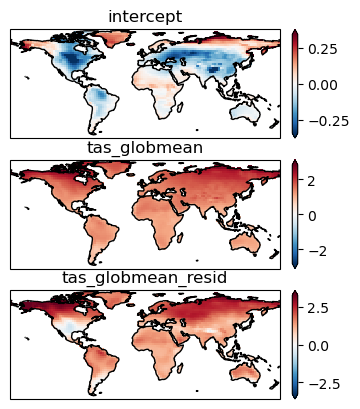

In [39]:
data_vars = (
    "intercept",
    "tas_globmean",
    "tas_globmean_resid",
)

f, axs = plt.subplots(
    3, 1, sharex=True, sharey=True, subplot_kw={"projection": ccrs.PlateCarree()}
)
axs = axs.flatten()

for ax, data_var in zip(axs, data_vars):

    da = local_forced_response_params[data_var]
    da = mesmer.grid.unstack_lat_lon_and_align(da, grid_orig)

    h = da.plot(
        ax=ax, label=data_var, robust=True, center=0, extend="both", add_colorbar=False
    )  # , vmax=3)

    ax.set_extent((-180, 180, -60, 85), ccrs.PlateCarree())
    cbar = plt.colorbar(h, ax=ax, extend="both", pad=0.025)  # , shrink=0.7)
    ax.set(title=data_var, xlabel="", ylabel="", xticks=[], yticks=[])
    ax.coastlines()

## Local variability
Now we need to fit the parameters for the AR(1) process used to emulate local variability:

$\eta_{s,t} = \gamma_{0, s} + \gamma_{1, 2} \cdot \eta_{s, t-1} + \nu_{s,t}, \ \nu_{s,t} \sim \mathcal{N}(0, \Sigma_{\nu}(r))$

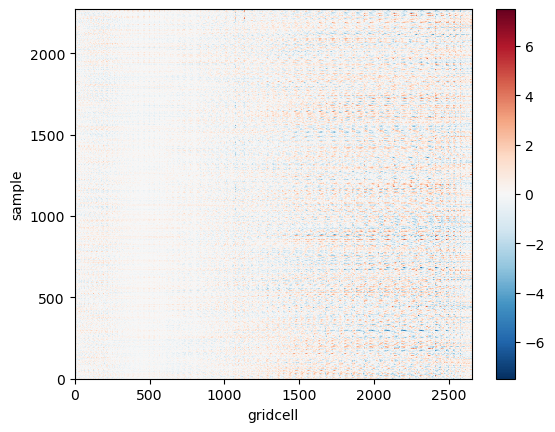

In [40]:
# get the residuals after linear regression
tas_stacked_residuals = local_lin_reg.residuals(
    predictors=predictors, target=tas_local_ds.tas
).T

tas_stacked_residuals.plot()

# unstack the residuals
tas_un_stacked_residuals = tas_stacked_residuals.set_index(
    sample=("time", "member", "scenario")
).unstack("sample")

### Estimate the AR parameters

In [41]:
# put each scenario into a datatree again, get rid of superfluous time steps and/or members
ssp585_resid = (
    tas_un_stacked_residuals.sel(scenario="ssp585")
    .dropna("member", how="all")
    .dropna("time")
    .drop_vars("scenario")
    .rename("tas")
)
ssp119_resid = (
    tas_un_stacked_residuals.sel(scenario="ssp119")
    .dropna("member", how="all")
    .dropna("time")
    .drop_vars("scenario")
    .rename("tas")
)
historical_resid = (
    tas_un_stacked_residuals.sel(scenario="historical")
    .dropna("member", how="all")
    .dropna("time")
    .drop_vars("scenario")
    .rename("tas")
)
dt_resids = DataTree.from_dict(
    {"ssp585": ssp585_resid, "ssp119": ssp119_resid, "historical": historical_resid}
)

In [42]:
data = (dt_resids["historical"].tas, dt_resids["ssp119"].tas, dt_resids["ssp585"].tas)
local_ar = mesmer.stats._fit_auto_regression_scen_ens(
    *data,
    ens_dim="member",
    dim="time",
    lags=1,
)

local_ar

<xarray.Dataset> Size: 127kB
Dimensions:    (gridcell: 2652, lags: 1)
Coordinates:
    lat        (gridcell) float64 21kB -53.75 -53.75 -51.25 ... 83.75 83.75
    lon        (gridcell) float64 21kB 288.8 291.2 286.2 ... 328.8 331.2 333.8
  * lags       (lags) int64 8B 1
Dimensions without coordinates: gridcell
Data variables:
    intercept  (gridcell) float64 21kB -0.005291 -0.005602 ... -0.000514
    coeffs     (gridcell, lags) float64 21kB 0.08111 0.06398 ... 0.2098 0.2193
    variance   (gridcell) float64 21kB 0.1406 0.1362 0.1235 ... 0.7202 0.7681
    nobs       (gridcell) float64 21kB 111.3 111.3 111.3 ... 111.3 111.3 111.3

### Estimate covariance matrix
For the covariance matrix of the white noise we first estimate the empirical covariance matrix of the gridcell's values and then localize it using the Gaspari-Cohn function, which converges to 0 for for distances bigger than the localisation radius. We find the best localisation radius by cross-validation and maximizing the loglikelihood.

Here we use stacked data again.

1. Prepare the distance matrix

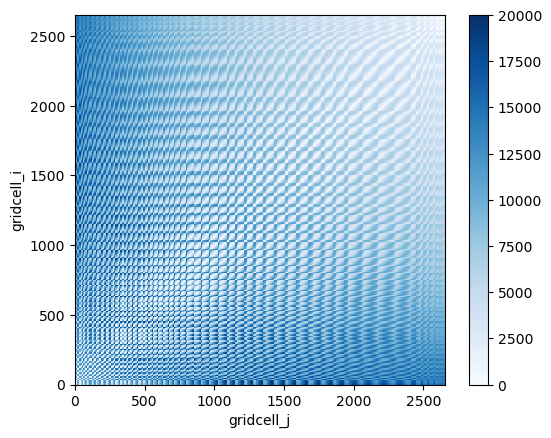

In [43]:
ds = dt_resids["historical"].tas
geodist = mesmer.geospatial.geodist_exact(ds.lon, ds.lat)

# plot
f, ax = plt.subplots()
geodist.plot(ax=ax, cmap="Blues")

ax.set_aspect("equal")

2. prepare the localizer(s) to regularize the covariance matrix

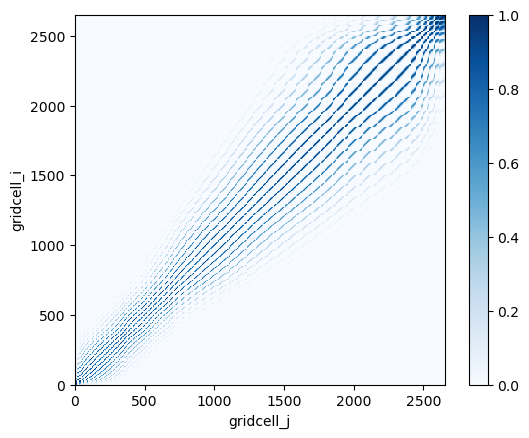

In [44]:
phi_gc_localizer = mesmer.stats.gaspari_cohn_correlation_matrices(
    geodist, range(2000, 8000, 500)
)

# plot one
f, ax = plt.subplots()
phi_gc_localizer[2000].plot(ax=ax, cmap="Blues")

ax.set_aspect("equal")

3. Compute the weights - each scenario has equal weight
If the user wants to give different weights to different scenarios or members then this can be adjusted

In [45]:
# reusing weights from local trend regression

4. find localized empirical covariance

In [46]:
dim = "sample"
k_folds = 15

localized_ecov = mesmer.stats.find_localized_empirical_covariance(
    tas_stacked_residuals, weights_stacked, phi_gc_localizer, dim, k_folds
)

localized_ecov

<xarray.Dataset> Size: 113MB
Dimensions:               (gridcell_i: 2652, gridcell_j: 2652)
Dimensions without coordinates: gridcell_i, gridcell_j
Data variables:
    localization_radius   int64 8B 4500
    covariance            (gridcell_i, gridcell_j) float64 56MB 0.1596 ... 0....
    localized_covariance  (gridcell_i, gridcell_j) float64 56MB 0.1596 ... 0....

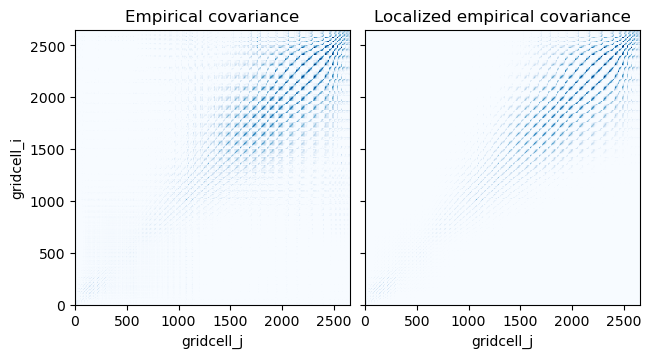

In [47]:
f, axs = plt.subplots(1, 2, sharey=True, constrained_layout=True)

opt = dict(vmin=0, vmax=1.5, cmap="Blues", add_colorbar=False)

ax = axs[0]
localized_ecov.covariance.plot(ax=ax, **opt)
ax.set_aspect("equal")
ax.set_title("Empirical covariance")

ax = axs[1]
localized_ecov.localized_covariance.plot(ax=ax, **opt)
ax.set_aspect("equal")
ax.set_title("Localized empirical covariance")
ax.set_ylabel("")
plt.show()

5. Adjust the regularized covariance matrix

In [48]:
localized_covariance_adjusted = mesmer.stats.adjust_covariance_ar1(
    localized_ecov.localized_covariance, local_ar.coeffs
)

# Emulation

In [49]:
# 0.1) load the parameters
# NOTE: already here now

# 0.2) get forcing data
# we now take the data from the smoothed global mean as dummy data
tas_globmean_forcing = xr.concat(
    [tas_globmean_smoothed["historical"].ds, tas_globmean_smoothed["ssp119"].ds],
    dim="time",
)
tas_globmean_forcing = tas_globmean_forcing.rename(tas="tas_globmean")

# 0.3) define parameters

n_realisations = 10

seed_global_variability = 0
seed_local_variability = 1_000_000

buffer_global_variability = 50
buffer_local_variability = 20

# ==========================================================================

# 1.) add the volcanic signal to the smooth global mean forcing

tas_globmean_forcing = mesmer.volc.superimpose_volcanic_influence(
    tas_globmean_forcing, volcanic_params, hist_period=HIST_PERIOD
)

# 2.) compute the global variability

global_variability = mesmer.stats.draw_auto_regression_uncorrelated(
    global_ar_params,
    realisation=n_realisations,
    time=tas_globmean_forcing.time,
    seed=seed_global_variability,
    buffer=buffer_global_variability,
)

# 3.) compute the local forced response

# TODO: split ``local_forced_response_params`` into a "forced_variability" and "local
# variability from global variability"

lr = mesmer.stats.LinearRegression()
lr.params = local_forced_response_params

# uses ``exclude`` to split the linear response
local_forced_response = lr.predict(tas_globmean_forcing, exclude={"tas_globmean_resid"})

# 4.) compute the local variability part driven by global variabilty

local_variability_from_global_var = local_lin_reg.predict(
    {"tas_globmean_resid": global_variability}, exclude={"tas_globmean", "intercept"}
)

# 5.) compute local variability
local_variability = mesmer.stats.draw_auto_regression_correlated(
    local_ar,
    localized_covariance_adjusted,
    time=tas_globmean_forcing.time,
    realisation=n_realisations,
    seed=seed_local_variability,
    buffer=buffer_local_variability,
)

local_variability_total = local_variability_from_global_var + local_variability

emulation_119 = local_forced_response + local_variability_total

In [50]:
# to the same for high emission scenario
# 0.1) load the parameters
# NOTE: already here now

# 0.2) get forcing data
# we now take the data from the smoothed global mean as dummy data
tas_globmean_forcing = xr.concat(
    [tas_globmean_smoothed["historical"].ds, tas_globmean_smoothed["ssp585"].ds],
    dim="time",
)
tas_globmean_forcing = tas_globmean_forcing.rename(tas="tas_globmean")

# 0.3) define parameters

n_realisations = 10

seed_global_variability = 0
seed_local_variability = 1_000_000

buffer_global_variability = 50
buffer_local_variability = 20

# ==========================================================================

# 1.) add the volcanic signal to the smooth global mean forcing

tas_globmean_forcing = mesmer.volc.superimpose_volcanic_influence(
    tas_globmean_forcing, volcanic_params, hist_period=HIST_PERIOD
)

# 2.) compute the global variability

global_variability = mesmer.stats.draw_auto_regression_uncorrelated(
    global_ar_params,
    realisation=n_realisations,
    time=tas_globmean_forcing.time,
    seed=seed_global_variability,
    buffer=buffer_global_variability,
)

# 3.) compute the local forced response

# TODO: split ``local_forced_response_params`` into a "forced_variability" and "local
# variability from global variability"

lr = mesmer.stats.LinearRegression()
lr.params = local_forced_response_params

# uses ``exclude`` to split the linear response
local_forced_response = lr.predict(tas_globmean_forcing, exclude={"tas_globmean_resid"})

# 4.) compute the local variability part driven by global variabilty

local_variability_from_global_var = local_lin_reg.predict(
    {"tas_globmean_resid": global_variability}, exclude={"tas_globmean", "intercept"}
)

# 5.) compute local variability
local_variability = mesmer.stats.draw_auto_regression_correlated(
    local_ar,
    localized_covariance_adjusted,
    time=tas_globmean_forcing.time,
    realisation=n_realisations,
    seed=seed_local_variability,
    buffer=buffer_local_variability,
)

local_variability_total = local_variability_from_global_var + local_variability

emulation_585 = local_forced_response + local_variability_total

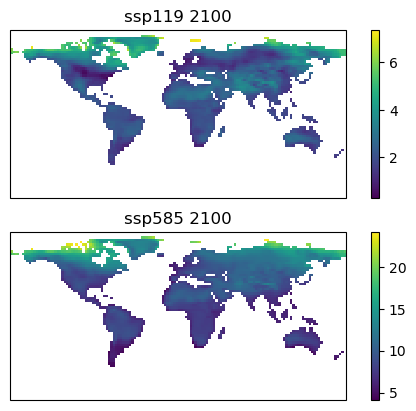

In [51]:
spatial_emu_119 = mesmer.grid.unstack_lat_lon_and_align(emulation_119, grid_orig)
spatial_emu_585 = mesmer.grid.unstack_lat_lon_and_align(emulation_585, grid_orig)

f, axs = plt.subplots(2, 1, subplot_kw={"projection": ccrs.PlateCarree()})

spatial_emu_119.isel(realisation=0).sel(time="2100").plot(ax=axs[0])
spatial_emu_585.isel(realisation=0).sel(time="2100").plot(ax=axs[1])

axs[0].set_title("ssp119 2100")
axs[1].set_title("ssp585 2100")
plt.show()

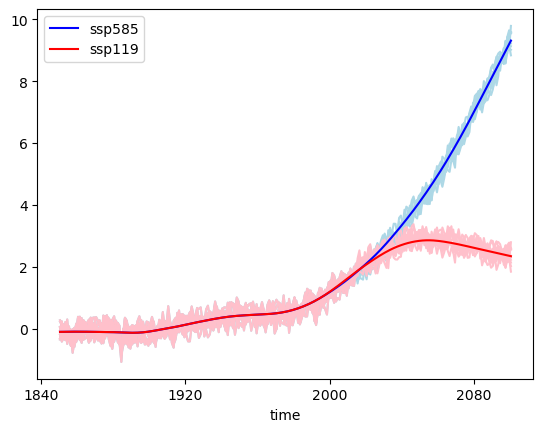

In [52]:
# plot global means
globmean_119 = mesmer.weighted.global_mean(spatial_emu_119)
globmean_585 = mesmer.weighted.global_mean(spatial_emu_585)

globmean_119_smoothed = mesmer.stats.lowess(
    globmean_119.mean("realisation"), dim="time", n_steps=n_steps, use_coords=False
)
globmean_585_smoothed = mesmer.stats.lowess(
    globmean_585.mean("realisation"), dim="time", n_steps=n_steps, use_coords=False
)

f, ax = plt.subplots()
globmean_585.plot.line(x="time", ax=ax, add_legend=False, color="lightblue")
globmean_119.plot.line(x="time", ax=ax, add_legend=False, color="pink")

globmean_585_smoothed.plot.line(x="time", ax=ax, color="blue", label="ssp585")
globmean_119_smoothed.plot.line(x="time", ax=ax, color="red", label="ssp119")

plt.legend()
plt.show()

Careful the above is the mean only over land, check if consistent with above.